# GOAT Debate

using a/b tests to determine if there's convincing evidence that player is clutch or choker in the playoffs

talk abt goat debate

[playoff data](https://www.kaggle.com/datasets/robertsunderhaft/nba-playoffs) <br>
[Basketball Reference](https://www.basketball-reference.com/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Players to be examined:**

- Michael Jordan
- LeBron James

# Cleaning Up Data

## Playoff Data

We can start by creating and cleaning up a DataFrame `playoffs_raw`. This data was found on a [Kaggle dataset](https://www.kaggle.com/datasets/robertsunderhaft/nba-playoffs).

`playoffs_raw` has a row for **every year that every player has been in the playoffs** among those players went to the playoffs. 

For example if player 'Suchit Bhayani' went to the playoffs in 2012 and 2015, there would be 2 rows in `playoffs_raw` for 'Suchit Bhayani', one for 2012 and one for 2015.

<u>*Note:*</u> Our data in `playoffs_raw` only contains data **up to the 2021-2022 season**. As a result, I omitted data from the `regular_season_raw` DataFrame for seasons after the cutoff.


In [2]:
playoffs_raw = pd.read_csv(r'C:\Users\suchi\Downloads\Clutch or Choker\playoffStats.csv.zip')
playoffs_raw

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ows,per,stl_pct,tov_pct,trb_pct,ts_pct,usg_pct,vorp,ws,ws_per_48
0,2022,Omer Yurtseven,C,23,MIA,9,0.0,4.2,1.3,2.0,...,0.1,25.8,0.0,0.0,10.8,0.647,22.6,0.1,0.2,0.228
1,2022,Kessler Edwards,SF,21,BRK,2,0.0,3.5,0.0,0.0,...,0.0,-2.2,7.3,100.0,0.0,NaN,6.6,0.0,0.0,-0.104
2,2022,Draymond Green,PF,31,GSW,22,22.0,32.0,3.1,6.5,...,0.4,12.3,1.8,26.4,12.7,0.534,14.0,0.5,1.4,0.094
3,2022,Danny Green,SF,34,PHI,12,12.0,26.6,3.0,7.4,...,0.0,9.9,2.0,12.7,7.1,0.576,15.1,0.3,0.3,0.049
4,2022,Devonte' Graham,PG,26,NOP,6,0.0,10.0,1.0,3.0,...,0.1,11.5,0.9,15.7,8.9,0.558,18.3,0.0,0.1,0.049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10643,1950,Stan Patrick,F-G,27,SHE,3,NaN,NaN,1.3,2.3,...,0.1,NaN,NaN,NaN,NaN,0.601,NaN,NaN,0.1,NaN
10644,1950,Warren Perkins,G-F,27,TRI,2,NaN,NaN,0.5,0.5,...,0.0,NaN,NaN,NaN,NaN,1.000,NaN,NaN,0.0,NaN
10645,1950,Ed Peterson,C,25,SYR,11,NaN,NaN,1.6,3.9,...,0.2,NaN,NaN,NaN,NaN,0.448,NaN,NaN,0.4,NaN
10646,1950,Jack Phelan,F,24,SHE,3,NaN,NaN,1.3,3.3,...,0.0,NaN,NaN,NaN,NaN,0.442,NaN,NaN,0.0,NaN


Each row consists of many stats, the ones we care about being:<br>
- pts_per_g = points per game<br>
- fg_per_g = field goals made per game<br>
- fga_per_g = field goals attempts per game<br>
- ft_per_g = free throws made per game<br>
- fta_per_g = free throws attempts per game<br>
- orb_per_g = offensive rebounds per game<br>
- drb_per_g = defensive rebounds per game<br>
- stl_per_g = steals per game<br>
- ast_per_g = assists per game<br>
- blk_per_g = blocks per game<br>
- tov_per_g = turnovers per game<br>
- g = # of games played

In [3]:
# queries out players we don't care about

playoffs_cleaning = playoffs_raw[(playoffs_raw.get('player') == 'Michael Jordan')  |
                       (playoffs_raw.get('player') == 'LeBron James')]

### Quantifying impact 

To quantify a player's impact on the court, we will use a **modified version** of game score (mGmSc) as a statistic.

mGmSc =  PTS + 0.4 * FG - 0.7 * FGA - 0.4*(FTA - FT) + 0.7 * ORB + 0.3 * DRB + STL + 0.7 * AST + 0.7 * BLK - TOV <br>
Traditional GmSc subtracts 0.4 for every personal foul, but we will not take this into account because the playoffs dataset does not contain personal fouls.

We define a function which calculates the mean mGmSc from the needed input.

In [4]:
def mGmSc_from_stats(PTS, FG, FGA, FTA, FT, ORB, DRB, STL, AST, BLK, TOV):
    return float(PTS) + 0.4 * float(FG) - 0.7 * float(FGA) - 0.4*(float(FTA) - float(FT)) + 0.7 * float(ORB) + 0.3 * float(DRB) + float(STL) + 0.7 * float(AST) + 0.7 * float(BLK) - float(TOV)

We can now calculate each player's mean mGmSc for each year of the player's playoff career.

In [5]:
# calculate the mean mGmSc for each playoff run for each player (so far)

m_gmscs = np.array([])
for index in playoffs_cleaning.index:
    m_gmsc = mGmSc_from_stats(playoffs_cleaning.loc[index].get('pts_per_g'),
                   playoffs_cleaning.loc[index].get('fg_per_g'),
                   playoffs_cleaning.loc[index].get('fga_per_g'),
                   playoffs_cleaning.loc[index].get('fta_per_g'),
                   playoffs_cleaning.loc[index].get('ft_per_g'),
                   playoffs_cleaning.loc[index].get('orb_per_g'),
                   playoffs_cleaning.loc[index].get('drb_per_g'),
                   playoffs_cleaning.loc[index].get('stl_per_g'),
                   playoffs_cleaning.loc[index].get('ast_per_g'),
                   playoffs_cleaning.loc[index].get('blk_per_g'),
                   playoffs_cleaning.loc[index].get('tov_per_g'))
    m_gmscs = np.append(m_gmscs, m_gmsc)
    
playoffs = playoffs_cleaning.assign(playoff_season_mean_mGmSc = m_gmscs).get(['player', 'season', 'playoff_season_mean_mGmSc'])
playoffs

,player,season,playoff_season_mean_mGmSc
335,LeBron James,2021,18.75
488,LeBron James,2020,25.86
921,LeBron James,2018,29.15
1123,LeBron James,2017,29.12
1353,LeBron James,2016,24.31
1553,LeBron James,2015,23.20
1806,LeBron James,2014,23.63
2118,LeBron James,2013,22.88
2316,LeBron James,2012,24.96
2475,LeBron James,2011,20.61


## Regular Season Data

We now have to calculate each player's mean mGmSc for each season of the player's regular season career. <br>
    
I went through [Basketball Reference](https://www.basketball-reference.com/) for the data, and added my own 'Player' column to specify whether it was a Michael Jordan (MJ) or LeBron James (LBJ) season.

In [6]:
reg_raw = pd.read_csv(r"C:\Users\suchi\Downloads\Clutch or Choker\MJ and LBJ Regular Season Averages - Sheet1.csv")

In [7]:
# getting rid of seasons where a player was retired.

reg_cleaning = reg_raw[reg_raw.get('Tm').str.contains('Did Not Play') == False]
reg_cleaning

,Player,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,MJ,1984-85,21,CHI,NBA,SG,82,82,38.3,10.2,...,0.845,2,4.5,6.5,5.9,2.4,0.8,3.5,3.5,28.2
1,MJ,1985-86,22,CHI,NBA,SG,18,7,25.1,8.3,...,0.84,1.3,2.3,3.6,2.9,2.1,1.2,2.5,2.6,22.7
2,MJ,1986-87,23,CHI,NBA,SG,82,82,40,13.4,...,0.857,2,3.2,5.2,4.6,2.9,1.5,3.3,2.9,37.1
3,MJ,1987-88,24,CHI,NBA,SG,82,82,40.4,13,...,0.841,1.7,3.8,5.5,5.9,3.2,1.6,3.1,3.3,35
4,MJ,1988-89,25,CHI,NBA,SG,81,81,40.2,11.9,...,0.85,1.8,6.2,8,8,2.9,0.8,3.6,3,32.5
5,MJ,1989-90,26,CHI,NBA,SG,82,82,39,12.6,...,0.848,1.7,5.1,6.9,6.3,2.8,0.7,3,2.9,33.6
6,MJ,1990-91,27,CHI,NBA,SG,82,82,37,12.1,...,0.851,1.4,4.6,6,5.5,2.7,1,2.5,2.8,31.5
7,MJ,1991-92,28,CHI,NBA,SG,80,80,38.8,11.8,...,0.832,1.1,5.3,6.4,6.1,2.3,0.9,2.5,2.5,30.1
8,MJ,1992-93,29,CHI,NBA,SG,78,78,39.3,12.7,...,0.837,1.7,5,6.7,5.5,2.8,0.8,2.7,2.4,32.6
10,MJ,1994-95,31,CHI,NBA,SG,17,17,39.3,9.8,...,0.801,1.5,5.4,6.9,5.3,1.8,0.8,2.1,2.8,26.9


We again need to calculate mGmSc for each season, and append it to our DataFrame.

In [8]:
m_gmscs = np.array([])
for index in reg_cleaning.index:
    m_gmsc = mGmSc_from_stats(reg_cleaning.loc[index].get('PTS'),
                   reg_cleaning.loc[index].get('FG'),
                   reg_cleaning.loc[index].get('FGA'),
                   reg_cleaning.loc[index].get('FTA'),
                   reg_cleaning.loc[index].get('FT'),
                   reg_cleaning.loc[index].get('ORB'),
                   reg_cleaning.loc[index].get('DRB'),
                   reg_cleaning.loc[index].get('STL'),
                   reg_cleaning.loc[index].get('AST'),
                   reg_cleaning.loc[index].get('BLK'),
                   reg_cleaning.loc[index].get('TOV'))
    m_gmscs = np.append(m_gmscs, m_gmsc)
    
reg = reg_cleaning.assign(regular_season_mean_mGmSc = m_gmscs).get(['Player', 'Season', 'regular_season_mean_mGmSc'])
reg

,Player,Season,regular_season_mean_mGmSc
0,MJ,1984-85,24.20
1,MJ,1985-86,16.91
2,MJ,1986-87,28.55
3,MJ,1987-88,30.12
4,MJ,1988-89,29.70
5,MJ,1989-90,28.74
6,MJ,1990-91,27.29
7,MJ,1991-92,25.47
8,MJ,1992-93,26.41
10,MJ,1994-95,20.16


# Plotting Data

## Michael Jordan

We plot the distribution of Jordan's the modified gamescores below for the Playoffs and Regular Season.

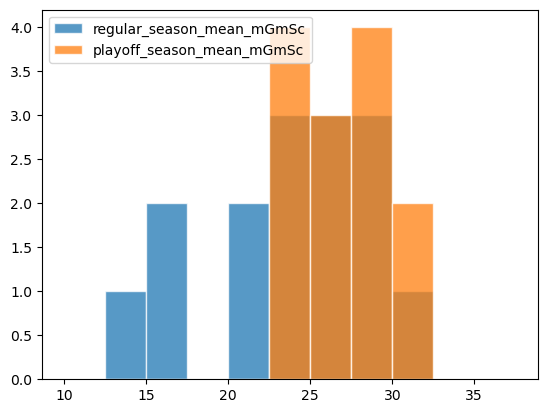

In [9]:
bins = np.arange(10, 40, 2.5)
mj_reg = reg[reg.get('Player') == 'MJ']
mj_playoffs = playoffs[playoffs.get('player') == 'Michael Jordan']

mj_reg_plot = mj_reg.get('regular_season_mean_mGmSc').hist(grid=False, ec='w', legend=True, bins=bins, alpha = 0.75)
mj_playoff_plot = mj_playoffs.get('playoff_season_mean_mGmSc').hist(grid=False, ec='w', legend=True, bins=bins, alpha=0.75)

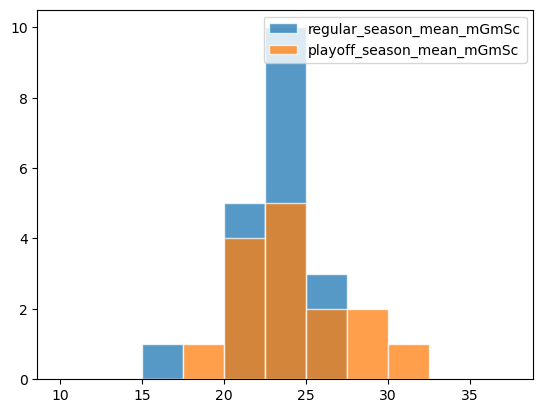

In [10]:
bins = np.arange(10, 40, 2.5)
lbj_reg = reg[reg.get('Player') == 'LBJ']
lbj_playoffs = playoffs[playoffs.get('player') == 'LeBron James']

lbj_reg_plot = lbj_reg.get('regular_season_mean_mGmSc').hist(grid=False, ec='w', legend=True, bins=bins, alpha = 0.75)
lbj_playoff_plot = lbj_playoffs.get('playoff_season_mean_mGmSc').hist(grid=False, ec='w', legend=True, bins=bins, alpha=0.75)

# Permutation Testing

We can see that on average, both Lebron James' and Michael Jordan's performance increases in the playoffs compared to the regular season. 

*But* could it be explained due to random chance? Or is it another confounding variable?

We will run a permutation test for each player to find out.

## Michael Jordan

In order to run a permutation test, we need to combine Jordan's regular season and playoff mGmSc DataFrames into a single DataFrame.

In [11]:
# columns in both DataFrames have to have the same name for concat method to work as we want it to
mj_reg_to_concat = mj_reg.assign(mGmSc=mj_reg.get('regular_season_mean_mGmSc')).get(['mGmSc'])
mj_playoffs_to_concat = mj_playoffs.assign(mGmSc=mj_playoffs.get('playoff_season_mean_mGmSc')).get(['mGmSc'])

mj_all_mGmSc = pd.concat([mj_reg_to_concat, mj_playoffs_to_concat], axis=0)

,mGmSc
0,24.20
1,16.91
2,28.55
3,30.12
4,29.70
5,28.74
6,27.29
7,25.47
8,26.41
10,20.16


### Hypotheses:

**Null:** Michael Jordan's performance in the regular season and in the playoffs is the same.

**Alternative:** Michael Jordan's performance in the playoffs increases compared to the regular season.

Let our alpha level = 0.05

### Test Statistic:

**test statistic** = mean of Michael Jordan's playoff run mGmSc means - mean of Michael Jordan's regular season mGmSc means

We calculate our observed statistic below:

In [12]:
mj_observed_stat = mj_playoffs_to_concat.get('mGmSc').mean() - mj_reg_to_concat.get('mGmSc').mean()
mj_observed_stat

3.302256410256412

### Simulating Under the Null:

Jordan had 13 and 15 seasons where he played in the playoffs and regular season, respectively. <br>Thus to simulate a test statistic, we can:

1. randomly shuffle the mGmSc column
2. take the first 13 mGmScs, and find their mean (simulates playoff mean mGmSc under the null)
3. take the the rest 15 mGmScs, and find their mean (simulates regular season mGmSc under the null)
4. subtract the 2 to find the test statistic

Repeat this process many, many times.

In [13]:
mj_test_stats = np.array([])

for i in np.arange(10000):
    mj_shuffled = mj_all_mGmSc.assign(mGmSc=np.random.permutation(mj_all_mGmSc.get('mGmSc')))
    playoff_mean = mj_shuffled.take(np.arange(12+1)).get('mGmSc').mean()
    regular_season_mean = mj_shuffled.take(np.arange(13, mj_shuffled.shape[0])).get('mGmSc').mean()
    test_stat = playoff_mean - regular_season_mean
    mj_test_stats = np.append(mj_test_stats, test_stat)

### Plotting Our Simulations:

Vertical bar in black represents our observed statistic.

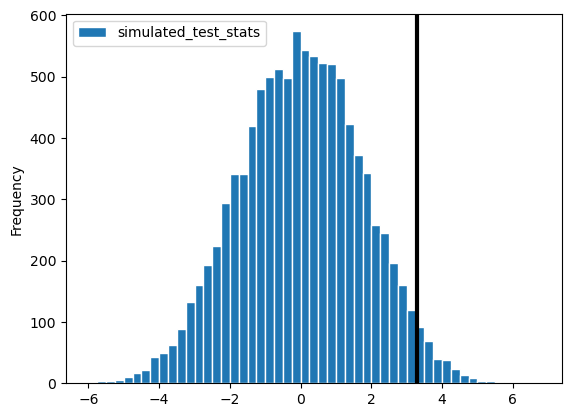

In [14]:
t = pd.DataFrame().assign(simulated_test_stats=mj_test_stats)
t.plot(kind='hist', ec='w', bins = np.arange(-6, 7, 0.25))
plt.axvline(x=mj_observed_stat, label='observed statistic', color='black', linewidth=3)

### Calculating our p-value:

In [15]:
mj_p_value = np.count_nonzero(mj_test_stats >= mj_observed_stat) / len(mj_test_stats)
mj_p_value

0.027

### Conclusion:

Because our p-value < our alpha level = 0.05, we **reject** the null. We have convincing evidence that Michael Jordan's performance increases in the playoffs compared to the regular season.

## LeBron James

In order to run a permutation test, we need to combine James' regular season and playoff mGmSc DataFrames into a single DataFrame.

In [16]:
# columns in both DataFrames have to have the same name for concat method to work as we want it to
lbj_reg_to_concat = lbj_reg.assign(mGmSc=lbj_reg.get('regular_season_mean_mGmSc')).get(['mGmSc'])
lbj_playoffs_to_concat = lbj_playoffs.assign(mGmSc=lbj_playoffs.get('playoff_season_mean_mGmSc')).get(['mGmSc'])

lbj_all_mGmSc = pd.concat([lbj_reg_to_concat, lbj_playoffs_to_concat], axis=0)
lbj_all_mGmSc

,mGmSc
19,15.16
20,22.80
21,24.53
22,21.19
23,25.01
24,24.82
25,26.18
26,22.55
27,23.48
28,25.09
